# Анализ рынка заведений общественного питания Москвы

Задача: провести иследование рынка общественного питания г. Москвы, выяснить текущее положение и дальнейшие возможности для захвата своей доли рынка.

## 1. Предобработка данных

In [1]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import requests
import re
from array import array 
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import graph_objects as go


In [2]:
rest_data = pd.read_csv('/datasets/rest_data.csv')
print(rest_data.info())
print(rest_data.isnull().sum())
#приведем данные обьектов и адреса к нижнему регистру, а также уберем лишние пробелы и кавычки
rest_data['object_name'] = rest_data['object_name'].str.lower()
rest_data['object_name'] = rest_data['object_name'].str.replace('" "', '')
rest_data['object_name'] = rest_data['object_name'].str.replace('- ', '')
rest_data['object_name'] = rest_data['object_name'].str.replace('кафе', '')
rest_data['object_name'] = rest_data['object_name'].str.replace('бар', '')
rest_data['object_name'] = rest_data['object_name'].str.replace('столовая', '')
rest_data['object_name'] = rest_data['object_name'].str.replace('кальянная', '')

rest_data['address'] = rest_data['address'].str.lower()

display(rest_data.head())
print(rest_data.duplicated().sum()) #проверим наличие дубликатов


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB
None
id             0
object_name    0
chain          0
object_type    0
address        0
number         0
dtype: int64


,id,object_name,chain,object_type,address,number
0,151635,сметана,нет,кафе,"город москва, улица егора абакумова, дом 9",48
1,77874,родник,нет,кафе,"город москва, улица талалихина, дом 2/1, корпус 1",35
2,24309,«академия»,нет,кафе,"город москва, абельмановская улица, дом 6",95
3,21894,пиццетория,да,кафе,"город москва, абрамцевская улица, дом 1",40
4,119365,«вишневая метель»,нет,кафе,"город москва, абрамцевская улица, дом 9, корпус 1",50


0


Типы данных в каждой колонке верны, пропущенные значения и дубликаты отсутствуют. Строки в столбце с адресом и наименованием обьекта приведены к нижнему регистру.

## 2. Анализ данных

['кафе' 'столовая' 'закусочная' 'предприятие быстрого обслуживания'
 'ресторан' 'кафетерий' 'буфет' 'бар' 'магазин (отдел кулинарии)']


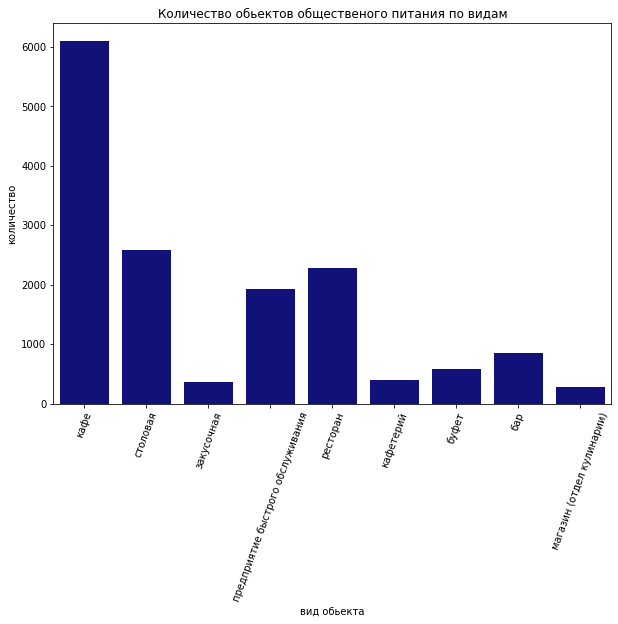

In [7]:
# определим количество обьектов общественного питания по их виду
print(rest_data['object_type'].unique()) #узнаем все виды обьектов общ.пит.
plt.figure(figsize=(10, 7))
sns.countplot(x='object_type', data=rest_data, color='darkblue') #построим график по количеству видов общ.пит.
plt.xticks(rotation=70)
plt.title("Количество обьектов общественого питания по видам")
plt.xlabel("вид обьекта")
plt.ylabel("количество")
plt.savefig('object_type_count.png', format='png', dpi=100)

Наиболее распространенным обьектом общественного питания в Москве является кафе, меньше всего в городе закусочных, кафетериев и магазинов(отделов кулинарии).

Text(0, 0.5, 'количество')

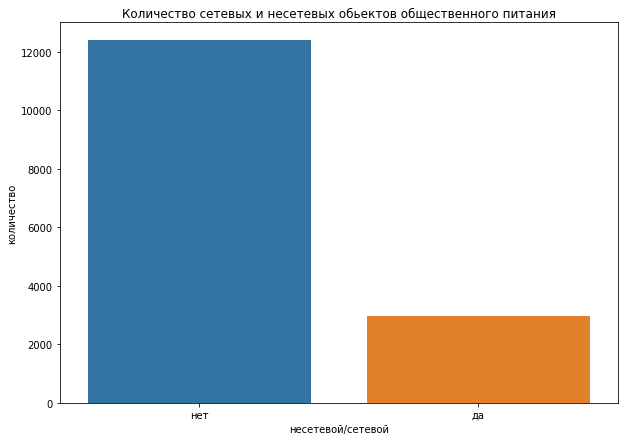

In [8]:
#определим соотношение сетевых и несетевых заведеений
plt.figure(figsize=(10, 7))
sns.countplot(x='chain', data=rest_data) 
plt.title("Количество сетевых и несетевых обьектов общественного питания")
plt.xlabel("несетевой/сетевой")
plt.ylabel("количество")

Несетевых заведений в Москве в разы выше. 

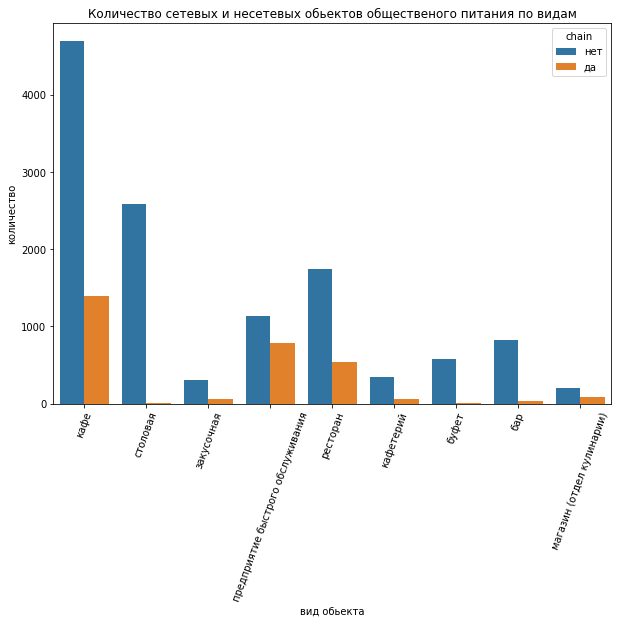

In [9]:
#построим график сетевых и несетевых обьектов по видам общ.пит.
plt.figure(figsize=(10, 7))
sns.countplot(x='object_type', data=rest_data, hue='chain') 
plt.xticks(rotation=70)
plt.title("Количество сетевых и несетевых обьектов общественого питания по видам")
plt.xlabel("вид обьекта")
plt.ylabel("количество")
plt.savefig('object_type_chain_count.png', format='png', dpi=100)

Сетевое распростанение наиболее характерно для предприятий быстрого обслуживания, для кафе, а также для ресторанов. Меньше всего сетевое распространение характерно для столовых и буфетов.

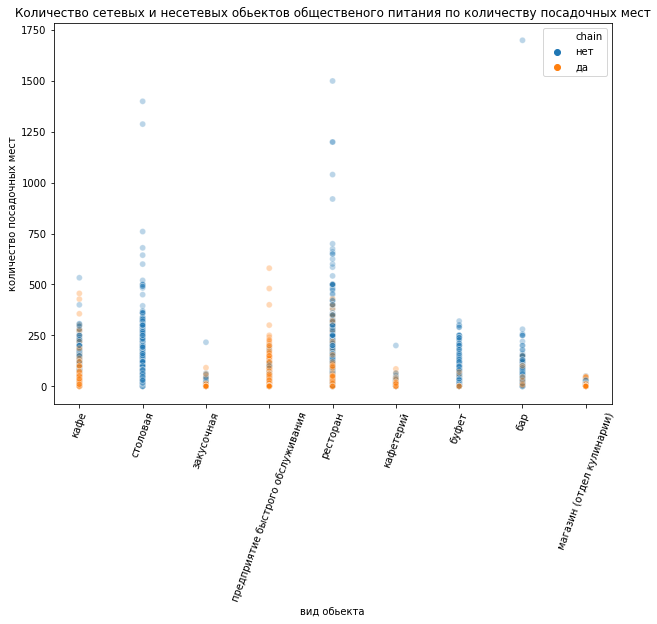

In [11]:
#построим график по количеству посадочных мест сетевых и несетевых обьектов общ.пит.
plt.figure(figsize=(10, 7))
sns.scatterplot(x='object_type', y='number', data=rest_data, hue='chain', alpha=.3)
plt.xticks(rotation=70)
plt.title("Количество сетевых и несетевых обьектов общественого питания по количеству посадочных мест")
plt.xlabel("вид обьекта")
plt.ylabel("количество посадочных мест")
plt.savefig('object_type_number_count.png', format='png', dpi=100)

В среднем для сетевых кафе характерно бОльшее количество посадочных мест, чем для несетевых. БольшОе количество посадочных мест характерно для ресторанов как для сетевых, так и для несетевых. Сетевые предпрития быстрого обслуживания имеют в среднем около 40 посадочных мест, что в 6 раз превышает среднее число посадочных мест несетевых предприятий быстрого обслуживания.

   chain                        object_type  mean_number  count
0    нет                           столовая   130.267415   2584
1     да                           столовая   112.333333      3
2     да                           ресторан   100.233456    544
3    нет                           ресторан    95.771970   1741
4     да                                бар    53.027027     37
5    нет                              буфет    51.865854    574
6     да                               кафе    47.426934   1396
7    нет                                бар    43.063492    819
8     да  предприятие быстрого обслуживания    40.166877    791
9    нет                               кафе    37.427174   4703
10    да                         закусочная    14.375000     56
11    да                              буфет    12.727273     11
12    да                          кафетерий    12.269231     52
13    да          магазин (отдел кулинарии)     8.679487     78
14   нет                          кафете

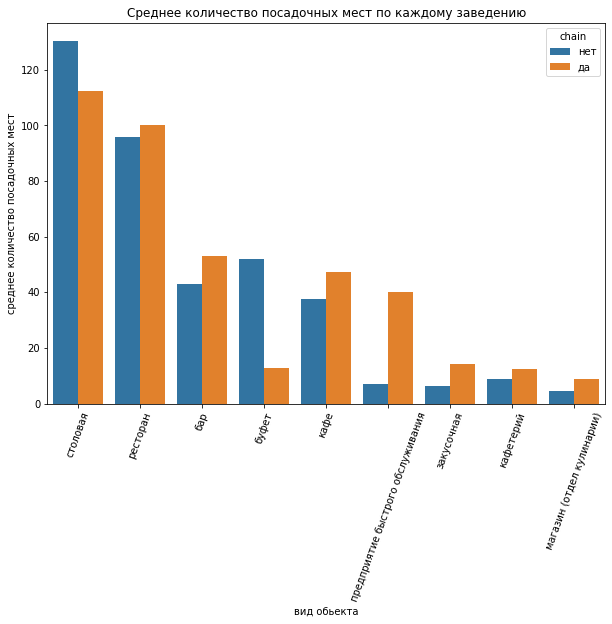

In [12]:
#найдем среднее количество посадочных мест по каждому типу заведения с учетом того, является ли заведение сетевым 
mean_number = rest_data.groupby(['chain', 'object_type'])\
.agg({'number': 'mean', 'id': 'count'})\
.sort_values(by='number', ascending=False)\
.reset_index()
mean_number.columns = ['chain', 'object_type', 'mean_number', 'count']
print(mean_number)

plt.figure(figsize=(10, 7))
sns.barplot(x='object_type', y='mean_number', data=mean_number, hue='chain')
plt.xticks(rotation=70)
plt.title("Среднее количество посадочных мест по каждому заведению")
plt.xlabel("вид обьекта")
plt.ylabel("среднее количество посадочных мест")
plt.savefig('mean_number_count.png', format='png', dpi=100)

В среднем наибольшее количество посадочных мест в категории столовая и ресторан, при этом в сетевых ресторанах, предприятий быстрого обслуживания и кафе посадочных мест больше, чем в несетевых, возможно это обусловлено широким распространением и высокой узнаваемостью среди несетевых предприятий общественного питания. 

In [13]:
#добавим в датафрем столбец с информацией об улице

streets_names = ['улица','проспект','шоссе','проезд',
                 'бульвар','переулок','набережная','площадь','вал','аллея']
 
def get_street(address):
    for position in [0,1,2]:
        for address_part in address.split(',')[position].split(' '):          
            if address_part in streets_names:
                street = address.split(', ')[position]
                return street
           
rest_data['street'] = rest_data['address'].apply(get_street)
display(rest_data.head())

#С помощью API найдем район для каждого адреса 
#from geopy.geocoders import Yandex
#geolocator = Yandex(api_key="7b82fe71-0003-4eea-8674-0cbde4f3722c")
#location = geolocator.geocode("москва, бабаевская улица, 3")
#location.address
#location.latitude, location.longitude
#geolocator.reverse([location.latitude, location.longitude], kind = 'district')
#def resolve_district(val):
    #location = geolocator.geocode(val, timeout = 300)
    #if location != None:        
        #return geolocator.reverse([location.latitude, location.longitude], kind = 'district')
#df.to_csv('out.csv', sep='\t', index=False)

data_district = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTYMGQXusik0iCTxGW-9epScqbBq5hiWhS-REG5SpOhBP_lo83RNrGWPiOA0NkNPL0o3mpsDvbP9eJI/pub?gid=189534247&single=true&output=csv')
display(data_district.head())
#отфильтруем данные о неизвестных районах и приведем к нужному формату
data_district = data_district.query('district != "???"')
data_district['object_name'] = data_district['object_name'].str.lower()
data_district['object_name'] = data_district['object_name'].str.replace('" "', '')
data_district['object_name'] = data_district['object_name'].str.replace('- ', '')
data_district['object_name'] = data_district['object_name'].str.replace('кафе', '')
data_district['object_name'] = data_district['object_name'].str.replace('бар', '')
data_district['object_name'] = data_district['object_name'].str.replace('столовая', '')
data_district['object_name'] = data_district['object_name'].str.replace('кальянная', '')

data_district['address'] = data_district['address'].str.lower()
print(data_district.info())
print(data_district.duplicated().sum()) #проверим дубликаты

#срединим два датафрейма в один и получим конечный вариант с улицами и районами
result = pd.merge(rest_data, data_district, how='left', on=['id', 'object_name', 'chain', 'object_type', 'address', 'number'])
display(result.head())



,id,object_name,chain,object_type,address,number,street
0,151635,сметана,нет,кафе,"город москва, улица егора абакумова, дом 9",48,улица егора абакумова
1,77874,родник,нет,кафе,"город москва, улица талалихина, дом 2/1, корпус 1",35,улица талалихина
2,24309,«академия»,нет,кафе,"город москва, абельмановская улица, дом 6",95,абельмановская улица
3,21894,пиццетория,да,кафе,"город москва, абрамцевская улица, дом 1",40,абрамцевская улица
4,119365,«вишневая метель»,нет,кафе,"город москва, абрамцевская улица, дом 9, корпус 1",50,абрамцевская улица


,id,object_name,chain,object_type,address,number,district
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,"Ярославский район, Северо-Восточный администра..."
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,"Таганский район, Центральный административный ..."
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,"Таганский район, Центральный административный ..."
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,"район Лианозово, Северо-Восточный администрати..."
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,"район Лианозово, Северо-Восточный администрати..."


<class 'pandas.core.frame.DataFrame'>
Int64Index: 15226 entries, 0 to 15365
Data columns (total 7 columns):
id             15226 non-null int64
object_name    15226 non-null object
chain          15226 non-null object
object_type    15226 non-null object
address        15226 non-null object
number         15226 non-null int64
district       15226 non-null object
dtypes: int64(2), object(5)
memory usage: 951.6+ KB
None
0


,id,object_name,chain,object_type,address,number,street,district
0,151635,сметана,нет,кафе,"город москва, улица егора абакумова, дом 9",48,улица егора абакумова,"Ярославский район, Северо-Восточный администра..."
1,77874,родник,нет,кафе,"город москва, улица талалихина, дом 2/1, корпус 1",35,улица талалихина,"Таганский район, Центральный административный ..."
2,24309,«академия»,нет,кафе,"город москва, абельмановская улица, дом 6",95,абельмановская улица,"Таганский район, Центральный административный ..."
3,21894,пиццетория,да,кафе,"город москва, абрамцевская улица, дом 1",40,абрамцевская улица,"район Лианозово, Северо-Восточный администрати..."
4,119365,«вишневая метель»,нет,кафе,"город москва, абрамцевская улица, дом 9, корпус 1",50,абрамцевская улица,"район Лианозово, Северо-Восточный администрати..."


,street,district,object_type
0,пресненская набережная,"Московский международный деловой центр Москва-Сити, Пресненский район, Центральный административный округ, Москва, Россия",167
1,ходынский бульвар,"микрорайон Ходынское Поле, Хорошёвский район, Северный административный округ, Москва, Россия",98
2,улица новый арбат,"район Арбат, Центральный административный округ, Москва, Россия",86
3,улица сущёвский вал,"район Марьина Роща, Северо-Восточный административный округ, Москва, Россия",81
4,пятницкая улица,"район Замоскворечье, Центральный административный округ, Москва, Россия",80
5,кировоградская улица,"район Чертаново Центральное, Южный административный округ, Москва, Россия",79
6,улица покровка,"Басманный район, Центральный административный округ, Москва, Россия",77
7,ленинградское шоссе,"Войковский район, Северный административный округ, Москва, Россия",72
8,улица земляной вал,"Басманный район, Центральный административный округ, Москва, Россия",69
9,тверская улица,"Тверской район, Центральный административный округ, Москва, Россия",68


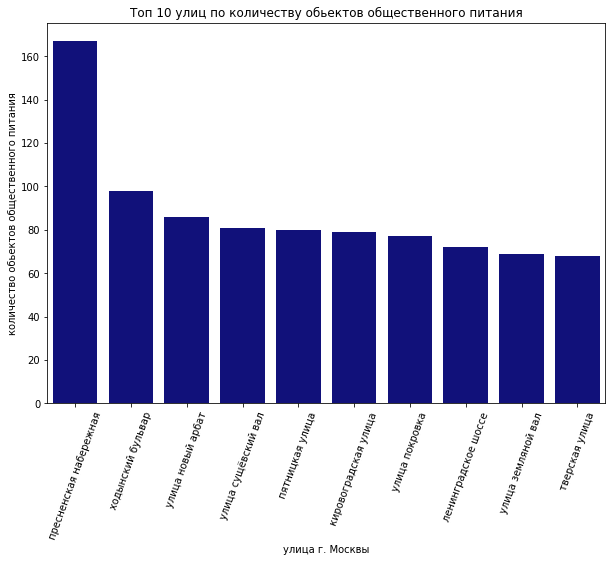

In [14]:
#сгруппирцем данные по улице и району и найдем количество обьектов общюпитания
top_10_street_district = result\
.groupby(['street', 'district'])['object_type']\
.count().sort_values(ascending=False).reset_index().head(10)
pd.set_option('display.max_colwidth', -1)
display(top_10_street_district)

plt.figure(figsize=(10, 7))
sns.barplot(x='street', y='object_type', data=top_10_street_district, color='darkblue')
plt.xticks(rotation=70)
plt.title("Топ 10 улиц по количеству обьектов общественного питания")
plt.xlabel("улица г. Москвы")
plt.ylabel("количество обьектов общественного питания")
plt.savefig('top_10_street_district.png', format='png', dpi=100)

Наибольшее количество обьектов общественного питания находятся в Центральном административном округе на улице Преснеенская набережная, также на Ходынском бульваре (Северный административный округ), на Новом арбате (Центральный административный округ) и др. Большое количество объектов общ. питания чаще всего сосредотачивается рядом с достопримечательностями и торгово-развлекательными комплексами города.

,street,district,object_type
0,яхромская улица,"18-й микрорайон, Дмитровский район, Северный административный округ, Москва, Россия",1
1,улица грина,"микрорайон 6А, район Северное Бутово, Юго-Западный административный округ, Москва, Россия",1
2,кулаков переулок,"Алексеевский район, Северо-Восточный административный округ, Москва, Россия",1
3,кузьминская улица,"район Кузьминки, Юго-Восточный административный округ, Москва, Россия",1
4,улица девятая рота,"район Преображенское, Восточный административный округ, Москва, Россия",1
...,...,...,...
928,13-я парковая улица,"район Восточное Измайлово, Восточный административный округ, Москва, Россия",1
929,электролитный проезд,"жилой комплекс В-Хаус, Нагорный район, Южный административный округ, Москва, Россия",1
930,12-й проезд марьиной рощи,"район Марьина Роща, Северо-Восточный административный округ, Москва, Россия",1
931,воротынская улица,"9-й микрорайон, район Куркино, Северо-Западный административный округ, Москва, Россия",1


,district,object_type
0,Таганский район,27
1,Тверской район,23
2,Басманный район,23
3,район Марьина Роща,19
4,Пресненский район,17
5,район Богородское,13
6,Даниловский район,12
7,район Замоскворечье,12
8,Мещанский район,12
9,Красносельский район,11


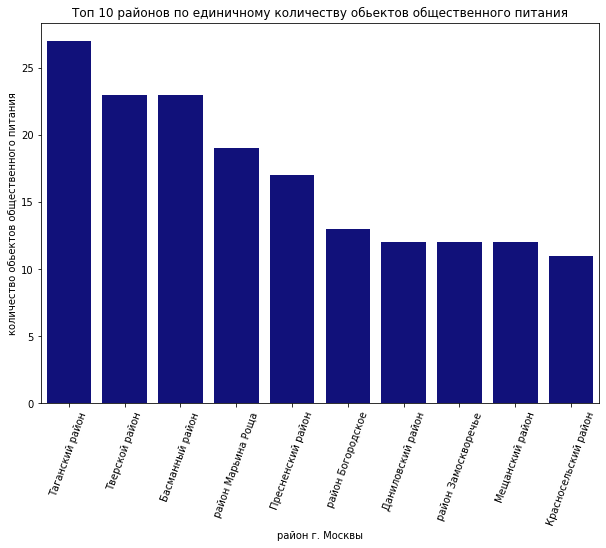

In [31]:
#Найдем число улиц с одним объектом общественного питания. 
one_object_street = result.groupby(['street', 'district'])['object_type'].count().sort_values().reset_index()
one_object_street = one_object_street.query('object_type < 2')
display(one_object_street)
one_object_street_district = one_object_street\
.groupby('district')['object_type'].count()\
.sort_values(ascending=False).reset_index().head(10)

one_object_street_district['district'] = one_object_street_district['district'].apply(lambda x: x.split(',')[0]) 
display(one_object_street_district)

plt.figure(figsize=(10, 7))
sns.barplot(x='district', y='object_type', data=one_object_street_district, color='darkblue')
plt.xticks(rotation=70)
plt.title("Топ 10 районов по единичному количеству обьектов общественного питания")
plt.xlabel("район г. Москвы")
plt.ylabel("количество обьектов общественного питания")
plt.savefig('one_object_street_district.png', format='png', dpi=100)

933 обьекта общественного питания одиноко (по одному на улицу) расположены на улицах г. Москвы. Больше всего таких обьектов в Таганском, Тверском, Басманном, Пресненском районах Центрального административного округа г. Москвы 

,street,district,object_type,number
0,пресненская набережная,"Московский международный деловой центр Москва-Сити, Пресненский район, Центральный административный округ, Москва, Россия",167,45.844311
1,ходынский бульвар,"микрорайон Ходынское Поле, Хорошёвский район, Северный административный округ, Москва, Россия",98,18.877551
2,улица новый арбат,"район Арбат, Центральный административный округ, Москва, Россия",86,53.779070
3,улица сущёвский вал,"район Марьина Роща, Северо-Восточный административный округ, Москва, Россия",81,26.617284
4,пятницкая улица,"район Замоскворечье, Центральный административный округ, Москва, Россия",80,64.850000
5,кировоградская улица,"район Чертаново Центральное, Южный административный округ, Москва, Россия",79,47.822785
6,улица покровка,"Басманный район, Центральный административный округ, Москва, Россия",77,50.714286
7,ленинградское шоссе,"Войковский район, Северный административный округ, Москва, Россия",72,37.861111
8,улица земляной вал,"Басманный район, Центральный административный округ, Москва, Россия",69,48.492754
9,тверская улица,"Тверской район, Центральный административный округ, Москва, Россия",68,71.735294


-0.19404290255949683


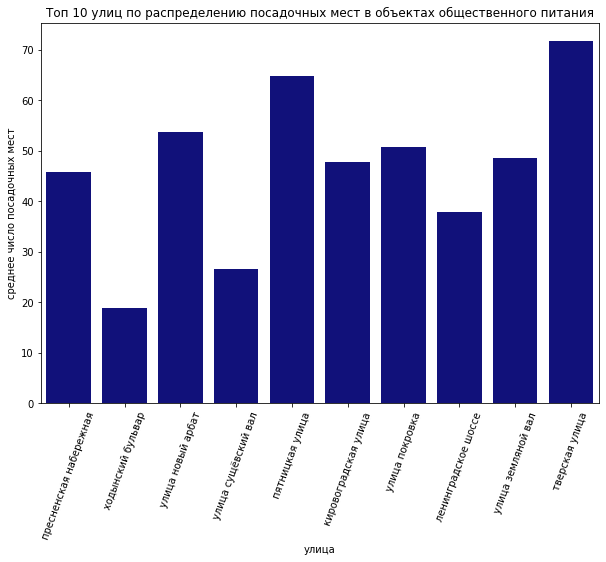

In [16]:
#найдем распределение среднего количества посадочных мест для улиц с большим количеством объектов общественного питания. 
top_street = result.groupby(['street', 'district'])['object_type','number']\
.agg({'object_type': 'count', 'number': 'mean'})\
.sort_values(by='object_type', ascending=False).reset_index().head(10)
display(top_street)
#найдем корреляцию между количеством обьектов на улице и среднем количеством мест
print(top_street['object_type'].corr(top_street['number']))
plt.figure(figsize=(10, 7))
sns.barplot(x='street', y='number', data=top_street, color='darkblue')
plt.xticks(rotation=70)
plt.title("Топ 10 улиц по распределению посадочных мест в объектах общественного питания")
plt.xlabel("улица")
plt.ylabel("среднее число посадочных мест")
plt.savefig('mean_number_to_street.png', format='png', dpi=100)

Между средним количеством посадочных мест и количеством заведений общ. питания существует обратная зависимость. Чем больше на улице обьектов общ. питания, тем меньше среднее количество посадочных мест. Скорее всего это связано с высокой конкуренцией и невозможностью на одной улице занять большую территорию для установки бОльшего количества посадочных мест для посетителей. Больше всего посадочных мест в заведениях общественного питания в Центральном округе Москвы на улицах: Тверская, Пятницкая и Новый Арбат

## 3. Вывод


1. Наиболее распространенным обьектом общественного питания в Москве является кафе, при этом несетевых заведений в Москве в разы выше. Сетевое распростанение наиболее характерно для предприятий быстрого обслуживания, кафе и ресторанов. 

2. Наибольшее количество обьектов общественного питания находятся в Центральном административном округе на улице Преснеенская набережная, также на Ходынском бульваре (Северный административный округ), на Новом арбате (Центральный административный округ). Большое количество объектов общ. питания чаще всего сосредотачивается рядом с достопримечательностями и торгово-развлекательными комплексами города. В тоже время в том же Центральном административном округе города Москвы в некоторых районах расположено только по одному обьекту общественного питания. Больше всего таких обьектов в Таганском, Тверском, Басманном, Пресненском районах Центрального административного округа г. Москвы. Данные районы можно изучить на проходимость, и рассмотреть их в качестве перспективных для открытия заведения.

4. Что касается среднего количества посадочных мест, то между ним и количеством заведений общ. питания существует обратная зависимость. Чем больше на улице обьектов общ. питания, тем меньше среднее количество посадочных мест. Скорее всего это связано с высокой конкуренцией на некоторых улицах и невозможностью на одной улице занять большую территорию для установки бОльшего количества посадочных мест для посетителей. Больше всего посадочных мест в заведениях общественного питания в Центральном округе Москвы на улицах: Тверская, Пятницкая и Новый Арбат

5. С целью получения постоянного потока клиентов (а следовательно и прибыли), предлагаю рассмотреть возможность открытия СЕТЕВОГО заведения общественного питания, которое будут обслуживать роботы. Сетевые рестораны широко распространены и уже зарекомендованы, что позволит не потерять клиентов, когда роботы-новинки перестанут их интересовать.   


## 4. Презентация

Ссылка на презентацию: <https://drive.google.com/file/d/1uz-7JzqQMXPWzywbgwyFYGFKg6XYpRtF/view?usp=sharing>
